# Test the package with the DBBMI dataset

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

rng = np.random.default_rng(42)

# load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

In [2]:
df

,age,bmi
0,0.03,13.235289
1,0.04,12.438775
2,0.04,14.541775
3,0.04,11.773954
4,0.04,15.325614
...,...,...
7289,21.45,19.329493
7290,21.47,21.562722
7291,21.54,23.355726
7292,21.68,24.869006


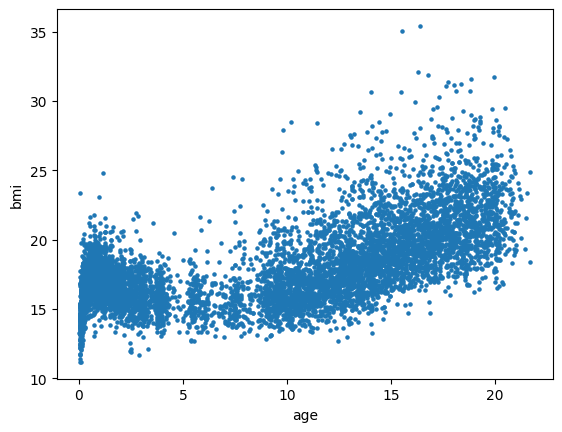

In [3]:
# plot the data
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [6]:
# set up design matrix 
X = tiger.Obs(name = "X_loc")
X.smooth(x = df["age"].to_numpy())

# set up hyperparameters
beta_loc = tiger.Var(0, name="beta_loc")
beta_scale = tiger.Var(100, name="beta_scale")

# set up parameters 
beta_dist = tiger.Dist(tfd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.zeros(X.X_smooth.shape[1]), distribution=beta_dist, name="beta")

# set up hyperparameters for the scale  
sigma_a = tiger.Var(0.01, name="a")
sigma_b = tiger.Var(0.01, name="b")

sigma_dist = tiger.Dist(tfd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, name="sigma")

# set up the linear predictor 
lpred = tiger.Lpred(X=X, name="loc", beta=beta)

# set up response distribution
y_dist = tiger.Dist(tfd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(y=df["bmi"].to_numpy(), distribution=y_dist)

In [7]:
beta.value.shape

(36,)

In [8]:
m.log_lik

Array([-4.0973883, -3.9951394, -4.27884  , ..., -5.9489737, -6.313862 ,
       -4.904777 ], dtype=float32)

In [9]:
m.log_prior

Array(-205.84006, dtype=float32)

In [10]:
m.log_prob

Array(-35863.363, dtype=float32)